#### Práctica 2: Tipología y ciclo de vida de los datos
# Análisis sobre enfermedades cardiacas
#### Autores: 
- Víctor H. Ayala Sánchez  
- Clara M. Roca de la Concha

# Tabla de contenidos

- 1. [Descripción del dataset](#1.-Descripción-del-dataset)
- 2. [Integración y selección de los datos de interés a analizar](#2.-Integración-y-selección-de-los-datos-de-interés-a-analizar)
- 3. [Limpieza de los datos](#3.-Limpieza-de-los-datos)
    - 3.1. [¿Los datos contienen ceros o elementos vacíos?](#3.1.-¿Los-datos-contienen-ceros-o-elementos-vacíos?)
    - 3.2. [Identifica y gestiona los valores extremos](#3.2.-Identifica-y-gestiona-los-valores-extremos)
- 4.[Análisis de los datos](#4.-Análisis-de-los-datos)
    - 4.1.[Selección de los grupos de datos que se quieren analizar/comparar](#4.1.-Selección-de-los-grupos-de-datos-que-se-quieren-analizar/comparar)
    - 4.2.[Comprobación de la normalidad y homogeneidad de la varianza](#4.2.-Comprobación-de-la-normalidad-y-homogeneidad-de-la-varianza)
    - 4.3.[Aplicación de pruebas estadísticas para comparar los grupos de datos](#4.3.-Aplicación-de-pruebas-estadísticas-para-comparar-los-grupos-de-datos)
    - 4.4.[Relación entre predictores](#4.4.-Relación-entre-predictores)
    - 4.5 [Modelaje Estadístico](#4.4.-Modelaje-Estadístico)
- 5.[Representación gráfica](#5.-Representación-gráfica)
- 6.[Resolución del problema](#6.-Resolución-del-problema)
- 7.[Código](#7.-Código)
- 8.[Vídeo](#8.-Vídeo)
- [Contribuciones](#Contribuciones)

# Librerías

In [257]:
import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import fligner
from scipy.stats import chi2_contingency
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from statsmodels.stats.proportion import test_proportions_2indep
from joblib import dump, load

# 1. Descripción del dataset

Partimos del dataset recomendado por la asignatura: [*Heart Attack Analysis & Prediction dataset*](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). En principio, este dataset trata de explicar la enfermedad cardiaca a partir de una serie de factores, como el colesterol o la frecuencia cardiaca. No obstante, aclararemos que este dataset es útil para practicar, pero no tanto para resolver un problema real, tal como ya se comenta [en el foro del propio dataset en Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/249239). 

En un análisis preliminar de los datos, podemos comprobar que el archivo `heart.csv` consta de 303 registros y 14 variables. La información de Kaggle es escasa, puesto que no proporciona información espacio-temporal sobre los datos. Tampoco proporciona citas adicionales sobre las fuentes, siendo que es improbable que los que proporcionan este dataset sean los autores de la investigación. Nótese que señalan la procedencia 'online' y el método 'crawling'. 

Una búsqueda rápida nos llevará a encontrar [el origen de los datos](https://archive.ics.uci.edu/ml/datasets/heart+disease). Se trata de un popular dataset donado en 1988. El estudio original consta de 4 ubicaciones:
1. Budapest (Hungría): Hungarian Institute of Cardiology, Andras Janosi, M.D.
2. Zurich (Suiza): University Hospital, William Steinbrunn, M.D.
3. Basilea (Suiza): University Hospital, Matthias Pfisterer, M.D.
4. Cleveland (Estados Unidos): V.A. Medical Center, Long Beach and Cleveland Clinic Foundation, Robert Detrano, M.D., Ph.D.

Originalmente, constaba de 76 atributos, si bien "todos los experimentos publicados se refieren a 14 atributos", tal como se nos indica [en el repositorio original](https://archive.ics.uci.edu/ml/datasets/heart+disease). Los datos compartidos en Kaggle proceden del dataset de Cleveland, el más popular en los estudios de Machine Learning. 

Por lo tanto, tenemos en nuestras manos un dataset cuya fuente original no está citada, con un número de registros menor al ideal en un estudio de estas características y de una antigüedad considerable. Presenta además algunas dificultades, como el hecho de que algunos valores no se corresponden con los establecidos en la descripción de los datos. Por ejemplo, la variable `cp` ('chest pain type') va del 0 al 3 mientras que en la descripción –tanto en kaggle como en el repositorio de UCI– va del 1 al 4. Instuitivamente cabe pensar que el 1 original pasó al 0 y el 4, al 3. Sin embargo, comparando los datos de Kaggle con el dataset original, podemos comprobar que esto no es así. Otros valores hacen saltar las alarmas, como la asignación en la variable `output`. Por este motivo, hemos tomado la decisión de partir directamente del dataset original, que se encuentra [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) bajo el nombre `processed.cleveland.data`.

Dicho esto, pasamos a describir las variables que tenemos entre manos:

`age`: edad del paciente

`sex`: sexo del paciente

        0 = mujer
        1 = hombre
        
        
`cp`: tipo de dolor de pecho. 

        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        4 = asintomático
        
`trestbps` : presión sanguínea en reposo (en mm Hg)

`chol` : colesterol en mg/dl

`fbs` : azúcar en sangre en ayunas > 120 mg/dl.

        0 = falso
        1 = verdadero
        
`restecg` : resultados electrocardiográficos en reposo

        0 = normal
        1 = anomalías en la onda ST-T
        2 = hipertrofia ventricular izquierda
        
`thalach` : frecuencia cardiaca máxima alcanzada.

`exang`: angina inducida por el ejercicio

        0 = no
        1 = sí
        
`oldpeak`: depresión del ST inducida por el ejercicio en relación con el reposo

`slope`: la pendiente del segmento ST de ejercicio máximo.

        1 = pendiente ascendiente 
        2 = sin pendiente
        3 = pendiente descendente
        
`ca`: número de vasos principales (de 0 a 3)

`thal`: Thallium Stress Test, por lo que podemos leer [aquí](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843?sort=votes)

        3 = normal
        6 = defecto arreglado
        7 = defecto reversible 

`num`: atributo predicho; diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfico)

        0 = ausencia de enfermedad cardíaca
        1, 2, 3 o 4 = presencia de enfermedad cardíaca

# 2. Integración y selección de los datos de interés a analizar

Usaremos el dataset al completo, teniendo en cuenta que ya es parte de una reducción del original, que contenía 76 variables. Dicho esto, sí realizaremos ciertas modificaciones que pasamos a describir aquí:

**1. Añadimos el nombre de las columnas, no presentes en el archivo.**

In [85]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang','oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv("data/processed.cleveland.csv", header=None, names=columns)
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2


**2. Convertimos los tipos de variable**

Vamos a homogeneizar el dataframe y pasar todo a *numeric*. Usaremos `errors='coerce'` para convertir en nulos los valores no numéricos.

In [86]:
df = df.apply(pd.to_numeric, errors='coerce')

**2. Recodificación de los valores**

Haremos lo siguiente:

a. Codificación de los valores de las variables categóricas con sus correspondientes etiquetas.

b. Unificamos todos los resultados en `num` de presencia de enfermedad cardíaca en 1 para que quede:
    
        0 = ausencia de enfermedad cardíaca
        1 = presencia de enfermedad cardíaca

In [107]:
df = df.replace({'sex':{1:'Male', 0:'Female'},
                 'cp': {1:'typical angina', 2:'atypical angina', 
                        3:'non-anginal pain', 4:'asymptomatic'},
                 'fbs':{0:'fastingBloodSugar_false',1:'fastingBloodSugar_true'},
                 'restecg':{0:'Normal',1:'ST-T wave abnormality',2:'Left ventricular hypertrophy'},
                 'exang':{1:'Yes Angina', 0:'No Angina'},
                 'slope':{1:'upsloping',2:'flat',3:'downsloping'},
                 'thal':{3:"normal", 6:"fixed defect", 7:"reversable defect"},
                 'num':{2: 1, 3: 1, 4: 1}})

df.sample(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
127,54.0,Male,asymptomatic,110.0,239.0,fastingBloodSugar_false,Normal,126.0,Yes Angina,2.8,flat,1.0,reversable defect,1
232,49.0,Male,non-anginal pain,118.0,243.0,fastingBloodSugar_false,Left ventricular hypertrophy,126.0,No Angina,0.8,upsloping,3.0,normal,1


# 3. Limpieza de los datos

## 3.1. ¿Los datos contienen ceros o elementos vacíos? 

En primer lugar, examinamos si existen valores nulos:

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    float64
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        299 non-null    float64
 12  thal      301 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 33.3+ KB


A continuación, podemos comprobar que, efectivamente, `ca`contiene 4 valores nulos y `thal`, 2. Podríamos ejecutar procesos como la imputación de valores KNN, para reemplazar estos valores por valores calculados en base a los valores del resto de variables, pero considerando que son solo 6 registros y que representan menos del 5% de los datos decidimos directamente eliminarlos.

In [108]:
df.dropna(inplace=True)

Por último, guardamos el archivo limpio con el nombre de `dataset_proc.csv`. Podríamos hacerlo en el siguiente punto, pero preferimos dejar los *outliers* en la versión final del dataset, puesto que a veces nos pueden resultar útiles.

In [109]:
df.to_csv("data/dataset_proc.csv", index=False)

## 3.2. Identifica y gestiona los valores extremos



Mediante el análisis gráfico de las distribuciones observamos algunos valores extremos en las variables `trestbps`, `chol`, `thalach` y `oldpeak`.

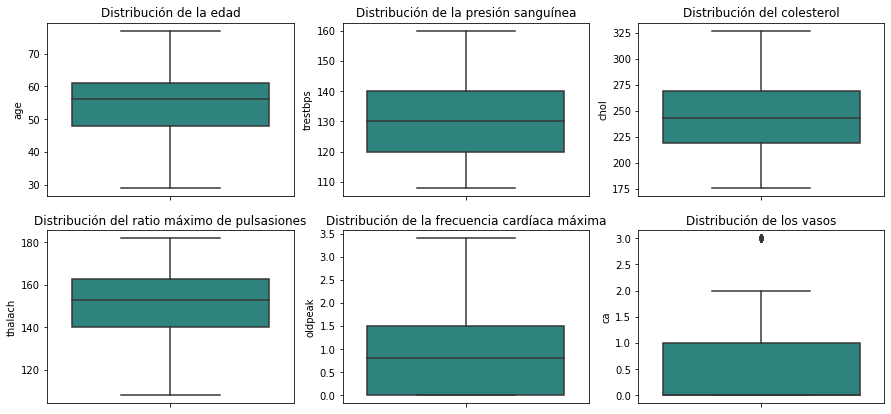

In [110]:
fig, axes = plt.subplots(2, 3, figsize=(15,7))
sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.boxplot(ax=axes[0,2], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.boxplot(ax=axes[1,0], y="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.boxplot(ax=axes[1,1], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[1,2], y="ca" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

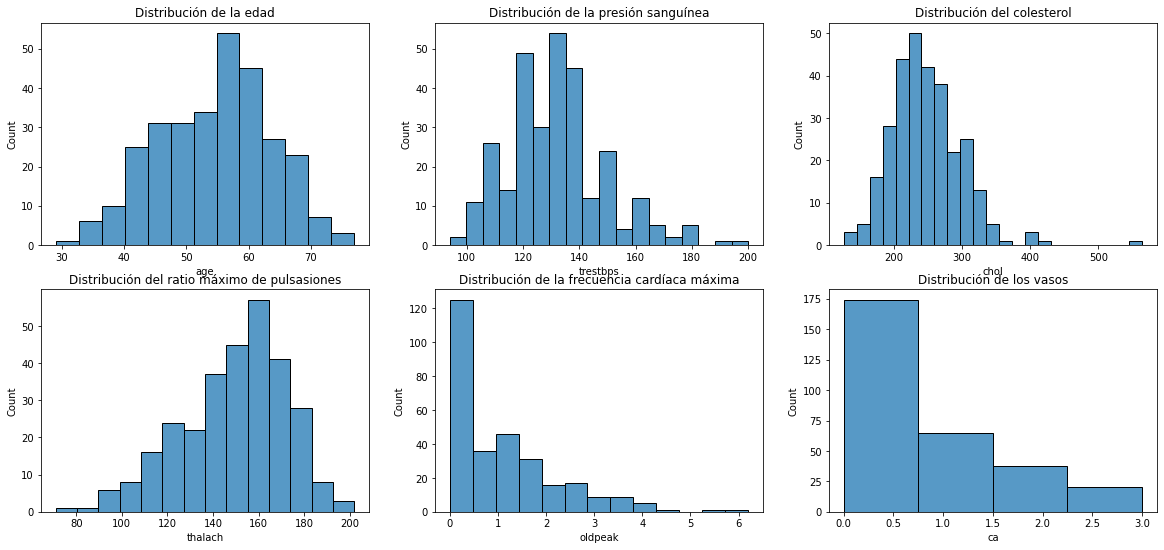

In [92]:
fig, axes = plt.subplots(2, 3, figsize=(20,9))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="trestbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')
sns.histplot(ax=axes[0,2], x="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')

sns.histplot(ax=axes[1,0], x="thalach" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')
sns.histplot(ax=axes[1,1], x="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.histplot(ax=axes[1,2], x="ca" ,palette="viridis", data=df, bins=4).set(title='Distribución de los vasos')
plt.show()

In [112]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,130.713805,245.030303,150.868687,0.896970,0.676768,0.461279
std,9.049736,12.870545,35.974781,18.162357,0.923542,0.938965,0.499340
min,29.000000,108.000000,176.000000,108.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,219.000000,140.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000,0.000000
75%,61.000000,140.000000,269.000000,163.000000,1.500000,1.000000,1.000000
max,77.000000,160.000000,327.000000,182.000000,3.400000,3.000000,1.000000


Además de los gráficos de boxplot, observando la tabla de estadísticos descriptivos podemos detectar valores máximos que se encuentran varias desviaciones por encima de la media, este caso se da en las distribuciones como en `trestbps`, `chol` o `thalach`.

Definimos la siguiente función para reemplazar aquellos valores que se encuentren por encima del percentil 95 o por debajo del percentil 5, considerados como valores extremos, dicho reemplazo se realizará por la mediana de la distribución.

In [94]:
def replaceOuliers(column):
    """
    """
    colReplace = np.array(column)
    median = np.median(column)
    
    upper =  np.percentile(np.array(column),95)
    lower =  np.percentile(np.array(column),5)    
    colReplace[colReplace[:] > upper] = median
    colReplace[colReplace[:] < lower] = median
    
    return list(colReplace)

In [95]:
df["trestbps"] = replaceOuliers(list(df["trestbps"]))
df["chol"] = replaceOuliers(list(df["chol"]))
df["thalach"] = replaceOuliers(list(df["thalach"]))
df["oldpeak"] = replaceOuliers(list(df["oldpeak"]))

# 4. Análisis de los datos

### Análisis exploratorio de datos

In [96]:
df[["age","trestbps","chol","thalach","oldpeak","ca"]].describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,130.713805,245.030303,150.868687,0.896970,0.676768
std,9.049736,12.870545,35.974781,18.162357,0.923542,0.938965
min,29.000000,108.000000,176.000000,108.000000,0.000000,0.000000
25%,48.000000,120.000000,219.000000,140.000000,0.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,269.000000,163.000000,1.500000,1.000000
max,77.000000,160.000000,327.000000,182.000000,3.400000,3.000000


A continuación se presentan las distribuciones de las variables en función del target o variable a predecir.

### `age`

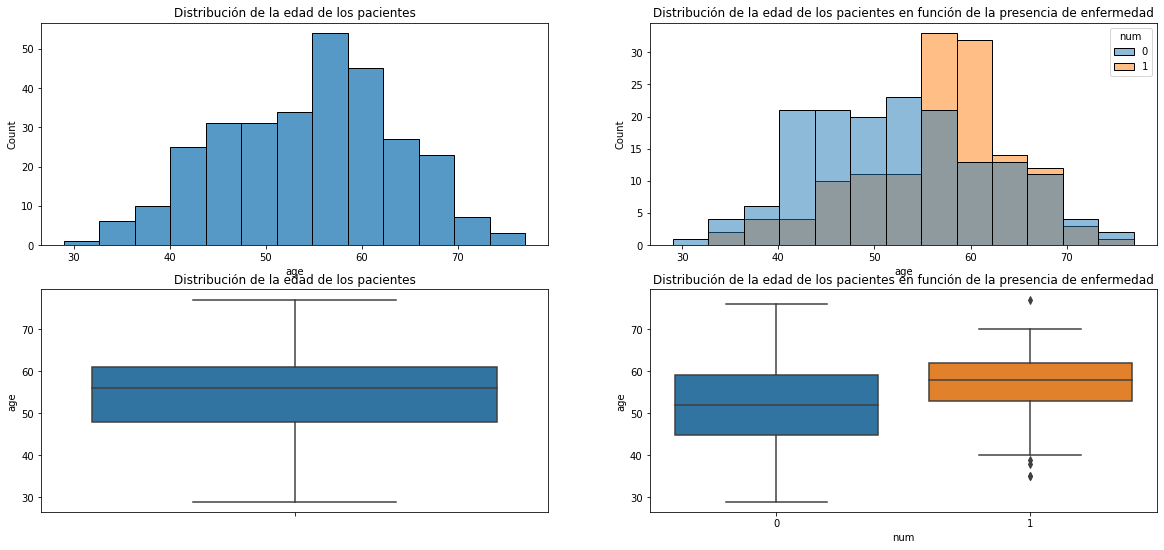

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))
sns.histplot(x=df["age"], ax=axes[0,0]).set(title='Distribución de la edad de los pacientes')
sns.histplot(x=df["age"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')
sns.boxplot(y=df["age"], ax=axes[1,0]).set(title='Distribución de la edad de los pacientes')
sns.boxplot(y=df["age"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')
plt.show()

In [98]:
df[["age","num"]].groupby("num").describe().T

num                 0           1
age count  160.000000  137.000000
    mean    52.643750   56.759124
    std      9.551151    7.899670
    min     29.000000   35.000000
    25%     44.750000   53.000000
    50%     52.000000   58.000000
    75%     59.000000   62.000000
    max     76.000000   77.000000

Se puede observar, comparando las distribuciones, que la mediana y el promedio de la edad de las personas que enferman es mayor que la de las personas sanas. 

### `sex`

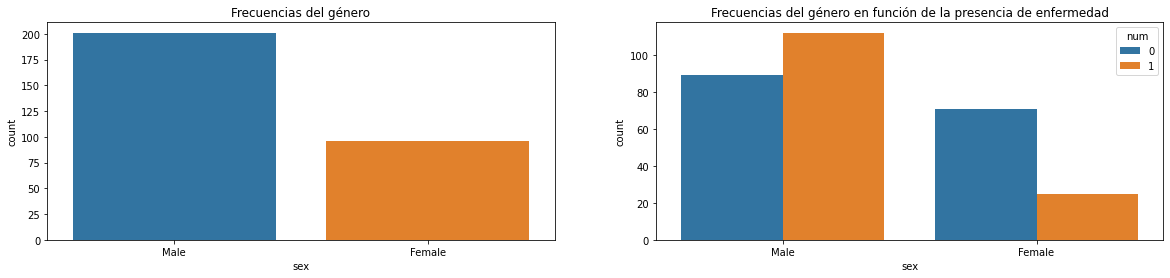

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))
sns.countplot(x=df["sex"], ax=axes[0]).set(title='Frecuencias del género')
sns.countplot(x=df["sex"], hue=df["num"], ax=axes[1]).set(title='Frecuencias del género en función de la presencia de enfermedad')
plt.show()

In [100]:
pd.crosstab(index= df["sex"], columns=df["num"], normalize=True)

num,0,1
sex,,
Female,0.239057,0.084175
Male,0.299663,0.377104


Se observa que la proporción de mujeres que enferman es baja dentro de la muestra estudiada.

### `cp`

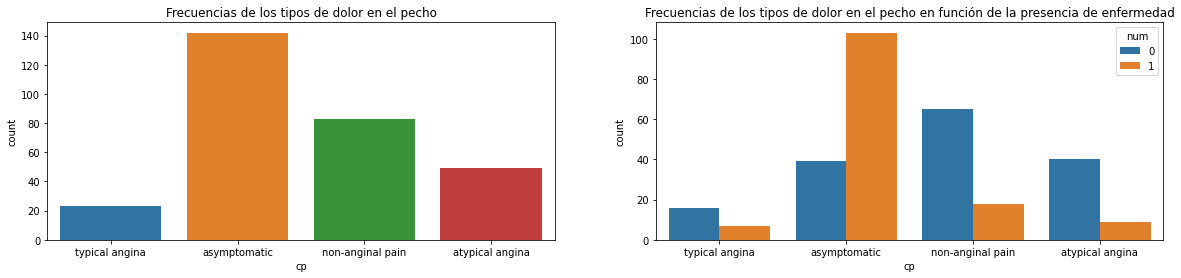

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))
sns.countplot(x=df["cp"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')
sns.countplot(x=df["cp"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')
plt.show()

In [106]:
pd.crosstab(index= df["cp"], columns=df["num"], normalize=True)

num,0,1
cp,,
asymptomatic,0.131313,0.346801
atypical angina,0.134680,0.030303
non-anginal pain,0.218855,0.060606
typical angina,0.053872,0.023569


Encontramos anomalías en esta variable. Nos parece muy extraño la frecuencia de los valores, dado que los casos asintomáticos son mayoritarios en los enfermos, mientras que en los sanos se reparte entre dolor no anginal, angina atípica y asintomáticos. Hemos vuelto al dataset original y estas conclusiones son coherentes con los datos. El dataset ofrecido en Kaggle tampoco nos daría solución ya que precisamente en esta variable había una mala codificación. Sería interesante contactar a los creadores del dataset para tratar de entender si estos los datos son o no un buen reflejo de la investigación.

### `trestbps`

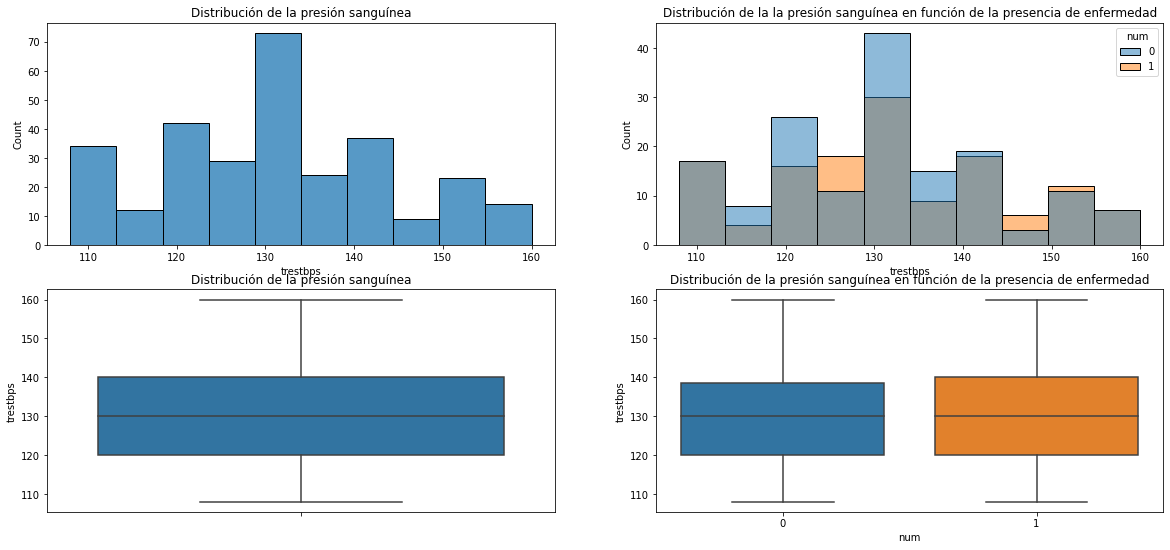

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["trestbps"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["trestbps"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["trestbps"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["trestbps"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

In [21]:
df[["trestbps","num"]].groupby("num").describe().T

num                      0           1
trestbps count  160.000000  137.000000
         mean   130.187500  131.328467
         std     12.447721   13.367052
         min    108.000000  108.000000
         25%    120.000000  120.000000
         50%    130.000000  130.000000
         75%    138.500000  140.000000
         max    160.000000  160.000000

Parece no haber grandes diferencias en los estadísticos de tendencia central en las distribuciones de las presión sanguínea entre personas enfermas y sanas.

### `chol`

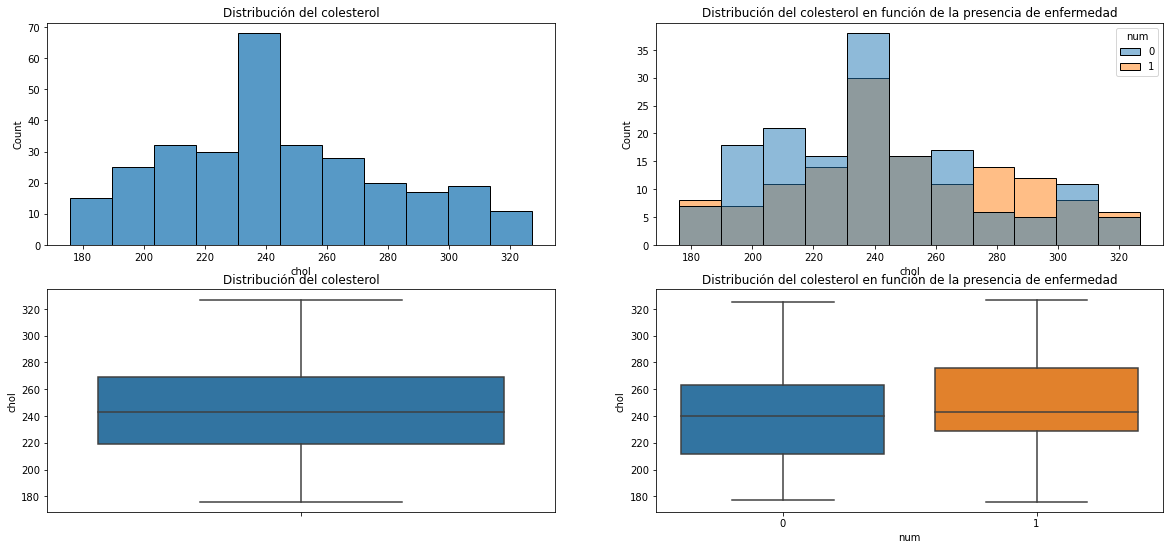

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["chol"], ax=axes[0,0]).set(title='Distribución del colesterol')
sns.histplot(x=df["chol"], hue=df["num"], ax=axes[0,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

sns.boxplot(y=df["chol"], ax=axes[1,0]).set(title='Distribución del colesterol')
sns.boxplot(y=df["chol"], x=df["num"], ax=axes[1,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

plt.show()

In [23]:
df[["chol","num"]].groupby("num").describe().T

num                  0           1
chol count  160.000000  137.000000
     mean   240.712500  250.072993
     std     35.456659   36.047484
     min    177.000000  176.000000
     25%    211.750000  229.000000
     50%    240.000000  243.000000
     75%    263.000000  276.000000
     max    325.000000  327.000000

El nivel de colesterol, en promedio, parece ser más elevado en las personas que presentan la enfermedad, sin embargo, existe una desviación importante.

### `fbs`

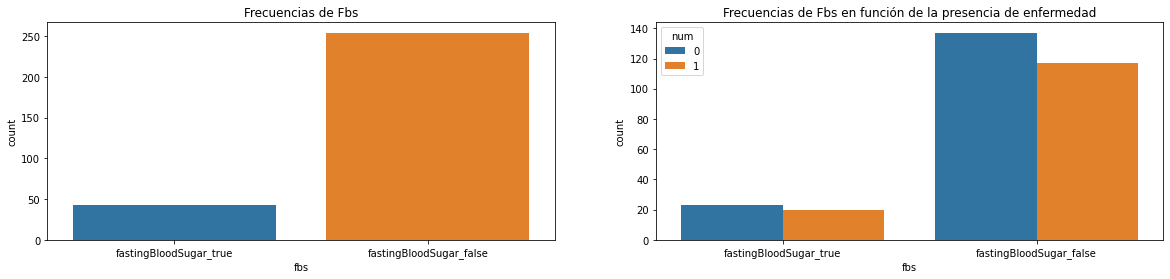

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["fbs"], ax=axes[0]).set(title='Frecuencias de Fbs')

sns.countplot(x=df["fbs"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de Fbs en función de la presencia de enfermedad')

plt.show()

In [25]:
pd.crosstab(index= df["fbs"], columns=df["num"], normalize=True)

num,0,1
fbs,,
fastingBloodSugar_false,0.461279,0.393939
fastingBloodSugar_true,0.077441,0.067340


El azúcar alto no parece un factor a la hora de determinar si existe enfermedad cardiaca.

### `restecg`

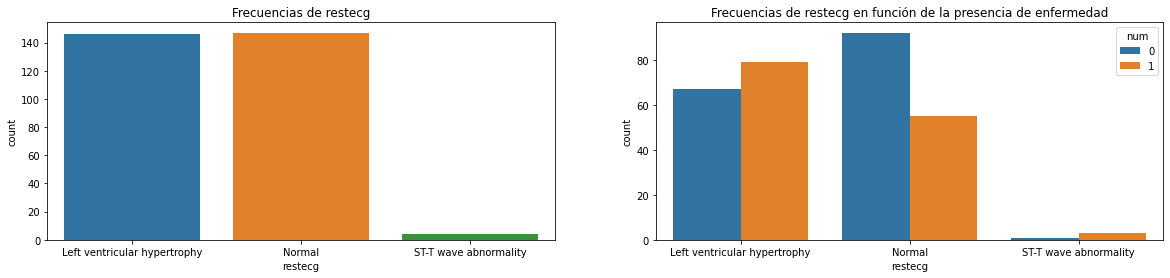

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.countplot(x=df["restecg"], ax=axes[0]).set(title='Frecuencias de restecg')

sns.countplot(x=df["restecg"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de restecg en función de la presencia de enfermedad')

plt.show()

In [27]:
pd.crosstab(index= df["restecg"], columns=df["num"], normalize=True)

num,0,1
restecg,,
Left ventricular hypertrophy,0.225589,0.265993
Normal,0.309764,0.185185
ST-T wave abnormality,0.003367,0.010101


La presencia de enfermedad se asocia en mayor proporción en los casos con hipertrofia ventricular izquierda en la muestra obtenida.

### `thalach`

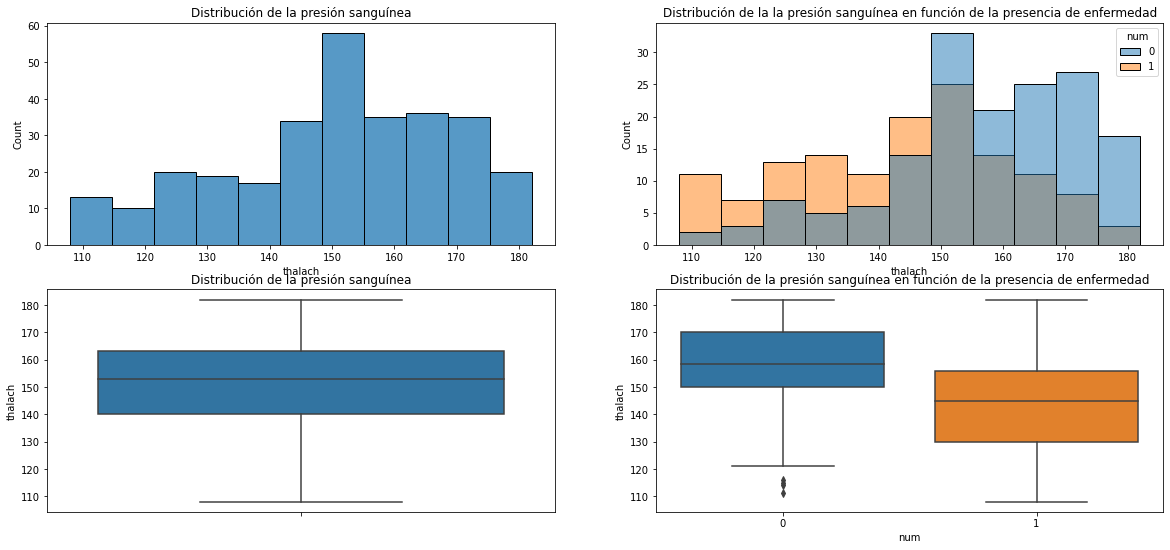

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["thalach"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["thalach"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["thalach"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["thalach"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

### `exang`

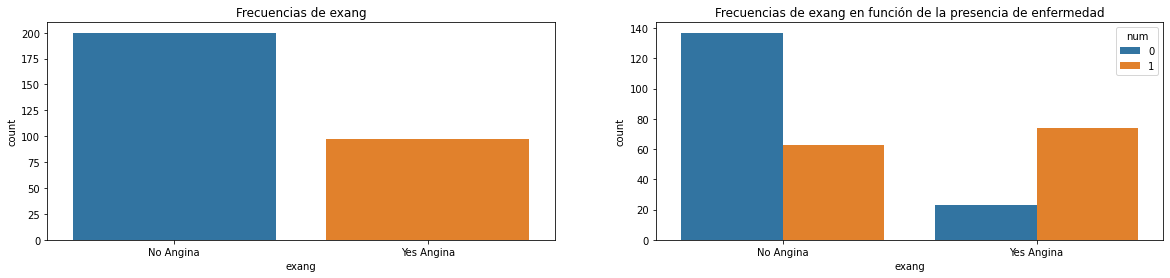

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20,4))
sns.countplot(x=df["exang"], ax=axes[0]).set(title='Frecuencias de exang')
sns.countplot(x=df["exang"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de exang en función de la presencia de enfermedad')
plt.show()

In [30]:
pd.crosstab(index= df["exang"], columns=df["num"], normalize=True)

num,0,1
exang,,
No Angina,0.461279,0.212121
Yes Angina,0.077441,0.249158


La presencia de angina tiene una mayor proporción de casos en los que está presente la enfermedad.

### `oldpeak`

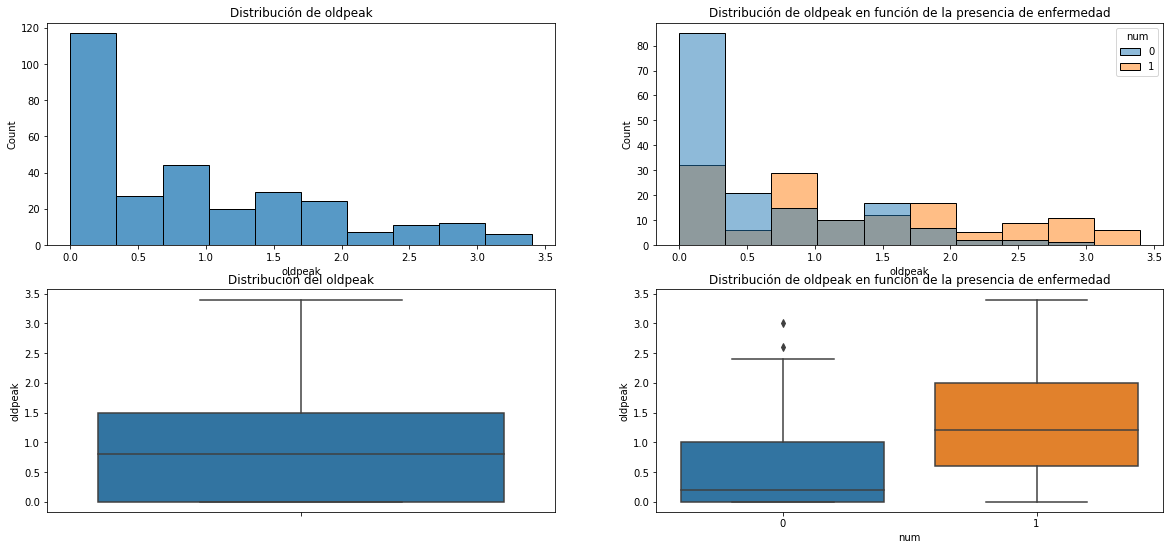

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["oldpeak"], ax=axes[0,0]).set(title='Distribución de oldpeak')
sns.histplot(x=df["oldpeak"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

sns.boxplot(y=df["oldpeak"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["oldpeak"], x=df["num"], ax=axes[1,1]).set(title='Distribución de oldpeak en función de la presencia de enfermedad')

plt.show()

In [32]:
df[["oldpeak","num"]].groupby("num").describe().T

num                     0           1
oldpeak count  160.000000  137.000000
        mean     0.560625    1.289781
        std      0.695818    1.000903
        min      0.000000    0.000000
        25%      0.000000    0.600000
        50%      0.200000    1.200000
        75%      1.000000    2.000000
        max      3.000000    3.400000

La presencia de enfermedad se asocia a mayores valores en depresión del ST inducida por el ejercicio en relación con el reposo.

### `slope`

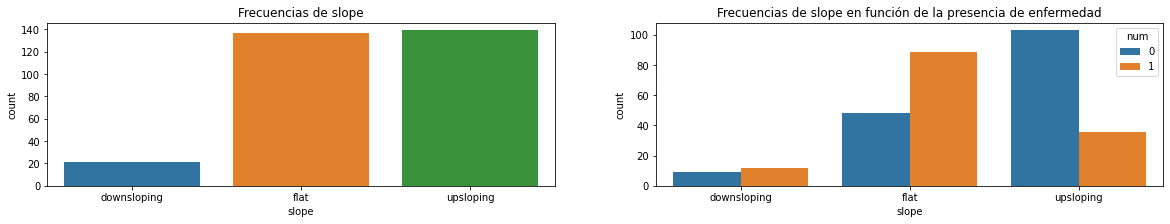

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20,3))

sns.countplot(x=df["slope"], ax=axes[0]).set(title='Frecuencias de slope')

sns.countplot(x=df["slope"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de slope en función de la presencia de enfermedad')

plt.show()

In [34]:
pd.crosstab(index= df["slope"], columns=df["num"], normalize=True)

num,0,1
slope,,
downsloping,0.030303,0.040404
flat,0.161616,0.299663
upsloping,0.346801,0.121212


La proporción mayor se da en enfermos cardiacos con la pendiente del segmento ST de ejercicio máximo sin pendiente.

### `ca`

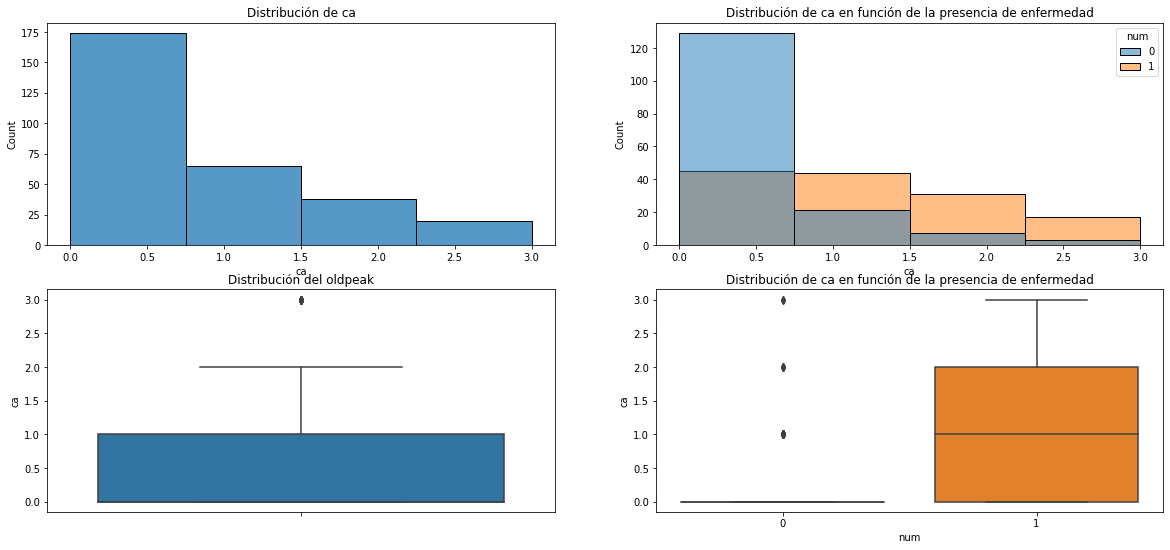

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(20,9))

sns.histplot(x=df["ca"], ax=axes[0,0], bins=4).set(title='Distribución de ca')
sns.histplot(x=df["ca"], hue=df["num"], ax=axes[0,1], bins=4).set(title='Distribución de ca en función de la presencia de enfermedad')

sns.boxplot(y=df["ca"], ax=axes[1,0]).set(title='Distribución del oldpeak')
sns.boxplot(y=df["ca"], x=df["num"], ax=axes[1,1]).set(title='Distribución de ca en función de la presencia de enfermedad')

plt.show()

In [116]:
df[["ca","num"]].groupby("num").describe().T

num                0           1
ca count  160.000000  137.000000
   mean     0.275000    1.145985
   std      0.633945    1.018506
   min      0.000000    0.000000
   25%      0.000000    0.000000
   50%      0.000000    1.000000
   75%      0.000000    2.000000
   max      3.000000    3.000000

La presencia de vasos es mayor en los casos de enfermos de la muestra.

### Thal

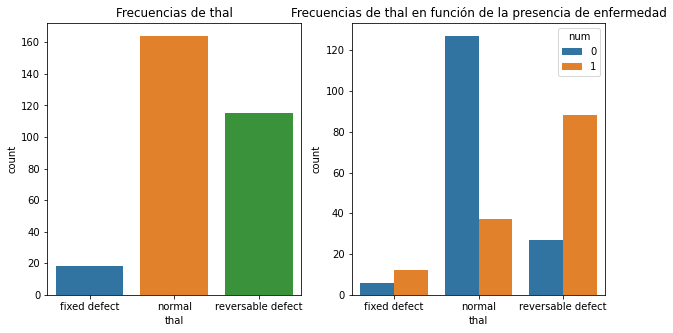

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x=df["thal"], ax=axes[0]).set(title='Frecuencias de thal')
sns.countplot(x=df["thal"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de thal en función de la presencia de enfermedad')
plt.show()

In [38]:
pd.crosstab(index= df["thal"], columns=df["num"], normalize=True)

num,0,1
thal,,
fixed defect,0.020202,0.040404
normal,0.427609,0.124579
reversable defect,0.090909,0.296296


Por lo general, los pacientes con resultados normales en el Thallium Stress Test, tienden a estar sanos, según los datos observados.

## 4.1. Selección de los grupos de datos que se quieren analizar/comparar 

A lo largo de la presente investigación se van a comparar los grupos de pacientes enfermos( valor num=1) y pacientes sanos (valor num=0). Por ello, procedemos a separar los datos en dos muestras.

In [42]:
df_sick = df[df["num"] == 1] 
df_healthy = df[df["num"] == 0] 

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza

Para comprobar la normalidad de las variables cuantitiativas utilizaremos el famoso test de Shapiro-Wilk. Recordemos que si el *p*-valor resulta ser menor de 0.05 (nivel de significación $\alpha$), rechazaremos la hipótesis nula, es decir, rechazaremos que los datos tienen una distribución normal. 

Para comprobar la homocedasticidad de los datos (variables cuantitativas), es decir, si existe una igualdad de varianzas entre dos grupos, aplicaremos el test no paramétrico de Levene para aquellas variables que siguen una normal y el test de Fligner-Killeen para las que no lo son. Recordemos que la premisa es la misma que con el test de Shapiro-Wilk: un *p*-valor inferior al nivel de significación $ \alpha $ supondrá el rechazo de la hipótesis nula y concluiremos que no existe homogeneidad de varianzas.

Para todos ellos, definimos una función para realizar los contrastes de forma más efectiva:

In [39]:
# Test de normalidad Shapiro-Wilk
def testNormality(x):
    """
    x: list type to check normality
    
    """
    a = np.array(x)
    stat, p = stats.shapiro(x)
    if p < 0.05:
        print("Distribution is not normal, p value: {}".format(p))
    else:
        print("Distribution is normal, p value: {}".format(p))

In [40]:
# Test de varianzas Levene en variables con distribución normal
def testLevene(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    a = np.array(listA)
    b = np.array(listB)
    stat, p = levene(a, b)  
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

In [41]:
# Test de varianzas Fligner-Killeen en variables con distribución no normal
def testFligner(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    a = np.array(listA)
    b = np.array(listB)
    stat, p = fligner(a, b)
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))

### `age`

In [43]:
print("\nTest de normalidad para la edad en población con patologías cardiacas:")
testNormality(df_sick["age"])
print("\nTest de normalidad para la edad en población sin patologías cardiacas:")
testNormality(df_healthy["age"])


Test de normalidad para la edad en población con patologías cardiacas:
Distribution is not normal, p value: 0.0016702482243999839

Test de normalidad para la edad en población sin patologías cardiacas:
Distribution is normal, p value: 0.11104635894298553


Siendo rigurosos, visto que una de las distribuciones no sigue una distribución normal, aplicaremos el Test Fligner-Killen para comparar las varianzas. Sin embargo, recordemos que el tamaño de las muestras es superior a 30, por lo tanto, según el Teorema Central del Límite, podríamos asumir que la distribución de la media de la muestra se asemeja a la de una normal.

In [44]:
print(len(df_sick))
print(len(df_healthy))

137
160


In [45]:
print("Test de varianza entre la edad en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["age"], df_healthy["age"])

Test de varianza entre la edad en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 0.003954117411351063


### `trestbps`

In [47]:
print("\nTest de normalidad para la presión sanguínea en reposo en población con patologías cardiacas:")
testNormality(df_sick["trestbps"])
print("\nTest de normalidad para la presión sanguínea en reposo en población sin patologías cardiacas:")
testNormality(df_healthy["trestbps"])


Test de normalidad para la presión sanguínea en reposo en población con patologías cardiacas:
Distribution is not normal, p value: 0.0011744850780814886

Test de normalidad para la presión sanguínea en reposo en población sin patologías cardiacas:
Distribution is not normal, p value: 0.00020238129945937544


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [48]:
print("Test de varianza entre la presión sanguínea en reposo en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["trestbps"], df_healthy["trestbps"])

Test de varianza entre la presión sanguínea en reposo en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.32114310607369934


### `chol`

In [49]:
print("\nTest de normalidad para el colesterol en población con patologías cardiacas:")
testNormality(df_sick["chol"])
print("\nTest de normalidad para el colesterol en población sin patologías cardiacas:")
testNormality(df_healthy["chol"])


Test de normalidad para el colesterol en población con patologías cardiacas:
Distribution is normal, p value: 0.10689220577478409

Test de normalidad para el colesterol en población sin patologías cardiacas:
Distribution is not normal, p value: 0.0006504325428977609


Como una de las distribuciones no es normal, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [50]:
print("Test de varianza entre el colesterol en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["chol"], df_healthy["chol"])

Test de varianza entre el colesterol en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.7886596720202534


### `thalach`

In [51]:
print("\nTest de normalidad para la frecuencia cardiaca máxima en población con patologías cardiacas:")
testNormality(df_sick["thalach"])
print("\nTest de normalidad para la frecuencia cardiaca máxima en población sin patologías cardiacas:")
testNormality(df_healthy["thalach"])


Test de normalidad para la frecuencia cardiaca máxima en población con patologías cardiacas:
Distribution is not normal, p value: 0.024152381345629692

Test de normalidad para la frecuencia cardiaca máxima en población sin patologías cardiacas:
Distribution is not normal, p value: 2.2021031327312812e-05


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [52]:
print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["thalach"], df_healthy["thalach"])

Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:
Variances equal, p value: 0.07540335575256349


### `oldpeak`

In [53]:
print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población con patologías cardiacas:")
testNormality(df_sick["oldpeak"])
print("\nTest de normalidad para la depresión del ST inducida por el ejercicio en población sin patologías cardiacas:")
testNormality(df_healthy["oldpeak"])


Test de normalidad para la depresión del ST inducida por el ejercicio en población con patologías cardiacas:
Distribution is not normal, p value: 3.473451670288341e-06

Test de normalidad para la depresión del ST inducida por el ejercicio en población sin patologías cardiacas:
Distribution is not normal, p value: 2.1279836616774905e-13


Como ambas distribuciones no son normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [54]:
print("Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["oldpeak"], df_healthy["oldpeak"])

Test de varianza entre la frecuencia cardiaca máxima en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 0.0002196641112224477


### `ca`

In [55]:
print("\nTest de normalidad para el número de vasos principales en población con patologías cardiacas:")
testNormality(df_sick["ca"])
print("\nTest de normalidad para el número de vasos principales en población sin patologías cardiacas:")
testNormality(df_healthy["ca"])


Test de normalidad para el número de vasos principales en población con patologías cardiacas:
Distribution is not normal, p value: 2.0717264015424064e-10

Test de normalidad para el número de vasos principales en población sin patologías cardiacas:
Distribution is not normal, p value: 2.7069059434691266e-21


Como ambas distribuciones son no normales, optamos por hacer el test de Fligner-Killeen para la homocedasticidad.

In [56]:
print("Test de varianza entre el número de vasos principales en pacientes con patologías caridacas y sin ellas:")
testFligner(df_sick["ca"], df_healthy["ca"])

Test de varianza entre el número de vasos principales en pacientes con patologías caridacas y sin ellas:
Variances not equal, p value: 6.981563629337983e-11


Como ya hemos comentado, por el tamaño muestral podríamos haber asumido normalidad y optado por el Test Levene en todas ellas. Hemos hecho también dicho test, aunque no lo ponemos aquí por cuestiones de espacio, y la conclusión ha sido en todas ocasiones la misma.

Exponemos a continuación la tabla resumen.

| **Variable** | **Test de normalidad** (enfermos / sanos) | **Test de igualdad de varianzas** |
|---|---|---|
| age | Distribución no normal / Distribución normal | Varianzas no iguales |
| trestbps | Distribución no normal / Distribución no normal | Varianzas iguales |
| chol | Distribución normal / Distribución no normal | Varianzas iguales |
| thalach | Distribución no normal / Distribución no normal | Varianzas iguales |
| oldpeak | Distribución no normal / Distribución no normal | Varianzas no iguales |
| ca | Distribución no normal / Distribución no normal | Varianzas no iguales |

## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos

Se proponen los siguientes contrastes y pruebas estadísticas como parte del análisis:
1. Contraste de hipótesis sobre la independencia entre `cp` y la presencia/ausencia de enfermedad. Para esto se ejecutará una prueba Chi cuadrado.
2. Contraste de hipótesis sobre el promedio de colesterol (`chol`): prueba de dos muestras independientes sobre la media con varianza poblacional desconocida e igual.
3. Contraste de proporciones de enfermos en hombres y en mujeres.

### Contraste 1

Ejecutamos el primer contraste:

- $H_0$: `cp` y `num` son independientes.
- $H_1$: `cp` y `num` mantienen dependencia.

In [57]:
chiTest = chi2_contingency(np.array(pd.crosstab(index= df["cp"], columns=df["num"])))

print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%chiTest)

chisq-statistic=77.2758, p-value=0.0000, df=3 expected_frep=[[76.4983165  65.5016835 ]
 [26.3973064  22.6026936 ]
 [44.71380471 38.28619529]
 [12.39057239 10.60942761]]


Al ejecutar la prueba rechamos la $H_0$, se puede concluir desde el punto de vista estadístico que ambas variables mantienen dependencia. 

### Contraste 2

Nuestra meta con este test es contrastar la hipótesis de que el colesterol en enfermos cardiacos es mayor que en personas sin cardiopatías. Para ello, realizaremos un contraste de hipótesis de dos muestra independientes sobre la media con varianzas desconocidas e iguales, como pudimos comprobar en el apartado anterior.

En primer lugar, formulamos las hipótesis:

$H_0$: La media de `chol` es igual en pacientes enfermos que en sanos.

$H_1$: La media de `chol` es mayor en pacientes enfermos que en sanos.

Dicho de otro modo:

$H_0: \mu_1 = \mu_2$ 

$H_1: \mu_1 > \mu_2$ 

Siendo $\mu_1$ la media de `chol` en pacientes enfermos y $\mu_2$, la de pacientes sanos.

In [117]:
# No hace falta aclarar 'equal_var', ya que 'True' es la opción por default
stats.ttest_ind(df_sick["chol"], df_healthy["chol"], 
                alternative = 'greater')

Ttest_indResult(statistic=2.250632905868273, pvalue=0.01257259703198613)

Suponiendo que queremos hacer el contraste con un 95% de confianza, siendo (*p*-value) 0.0126 < 0.05 (nivel de confianza), rechazaremos la hipótesis nula; es decir, la media de `chol`es mayor en pacientes enfermos que en sanos con un 95% de confianza. Nótese, que para un test del 99% de confianza se aceptaría al hipótesis nula, aunque por poco.

### Contraste 3

Calculamos una tabla de doble entrada para saber las frecuencias y totales de ambas distribuciones.

In [59]:
pd.crosstab(index= df["sex"], columns=df["num"],margins=True)

num,0,1,All
sex,,,
Female,71,25,96
Male,89,112,201
All,160,137,297


Definimos las hipótesis del contraste de proporciones:

- $H_0: P_1=P_2$
- $H_1: P_1\neq P_2$

Ejecutamos el contraste de proporciones

In [60]:
testProp = test_proportions_2indep(count1=25, nobs1=96, count2=112, 
                                   nobs2=201, alternative="two-sided")
testProp.pvalue

2.653646299396361e-07

El p valor está por debajo de 0.05, por lo tanto rechazamos la hipótesis nula y podemos concluir que las proporciones de enfermos en hombres y mujeres difieren.

### 4.4.2. Relación entre predictores


A continuación estudiamos si hay relación entre los predictores, haciendo una matriz de correlaciones.

In [61]:
df[["age","trestbps","chol","thalach","ca"]].corr()

,age,trestbps,chol,thalach,ca
age,1.000000,0.276915,0.148061,-0.315545,0.362210
trestbps,0.276915,1.000000,0.063053,-0.045166,0.099667
chol,0.148061,0.063053,1.000000,-0.055738,0.150612
thalach,-0.315545,-0.045166,-0.055738,1.000000,-0.227342
ca,0.362210,0.099667,0.150612,-0.227342,1.000000


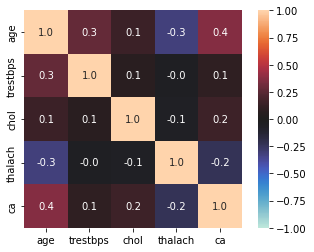

In [62]:
sns.heatmap(df[["age","trestbps","chol","thalach","ca"]].corr(),
            vmin=-1, vmax=1, center=0,
            square=True,
            annot=True,
            fmt=".1f")
plt.show()

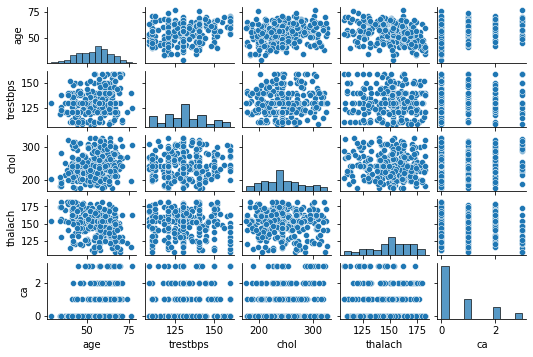

In [120]:
sns.pairplot(df[["age","trestbps","chol","thalach","ca"]],height=1,aspect=1.5)

Se concluye que no hay correlaciones elevadas entre las variables predictoras.

## 4.4. Modelaje Estadístico

Agregamos este apartado adicional de modelaje estadístico, dado que finalmente hicimos los tres tests, pero habíamos realizado este ejercicio primero. 

En primer lugar, realizamos un *one hot encoding* sobre las variables categóricas.

In [64]:
df = pd.get_dummies(df, prefix='sex', columns=["sex"], drop_first=True)
df = pd.get_dummies(df, prefix='cp', columns=["cp"], drop_first=True)
df = pd.get_dummies(df, prefix='fbs', columns=["fbs"], drop_first=True)
df = pd.get_dummies(df, prefix='restecg', columns=["restecg"], drop_first=True)
df = pd.get_dummies(df, prefix='exang', columns=["exang"], drop_first=True)
df = pd.get_dummies(df, prefix='slope', columns=["slope"], drop_first=True)
df = pd.get_dummies(df, prefix='thal', columns=["thal"], drop_first=True)

df.sample(2)

,age,trestbps,chol,thalach,oldpeak,ca,num,sex_Male,cp_atypical angina,cp_non-anginal pain,cp_typical angina,fbs_fastingBloodSugar_true,restecg_Normal,restecg_ST-T wave abnormality,exang_Yes Angina,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
112,52.0,118.0,186.0,153.0,0.0,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0
196,69.0,160.0,234.0,131.0,0.1,1.0,0,1,0,0,1,1,0,0,0,1,0,1,0


In [65]:
df.shape

(297, 19)

Elegimos probar 2 clasificadores:

In [66]:
logistcRegresion = LogisticRegression()
decisionTree = DecisionTreeClassifier()

Definimos estos parámetros para hacer *grid search*.

In [67]:
############### LR
logistcRegresion_params = {'C': [0.01,0.1,1,10,100,1000]}
############### DT
decisionTree_params = {"criterion":["gini","entropy"],"max_depth":[5,10,20]}

Separamos en `X` e `Y`.

In [68]:
X = df.loc[:, df.columns != 'num']
y = list(df["num"])

In [69]:
X.head(2)

,age,trestbps,chol,thalach,oldpeak,ca,sex_Male,cp_atypical angina,cp_non-anginal pain,cp_typical angina,fbs_fastingBloodSugar_true,restecg_Normal,restecg_ST-T wave abnormality,exang_Yes Angina,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63.0,145.0,233.0,150.0,2.3,0.0,1,0,0,1,1,0,0,0,0,0,0,0
1,67.0,160.0,286.0,108.0,1.5,3.0,1,0,0,0,0,0,0,1,1,0,1,0


In [70]:
y[0:3]

[0, 1, 1]

Escalamos todas las variables para que se encuentren en la misma escala de medición y evitar que unas tengan un mayor peso en las predicciones.

In [71]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Realizamos un *grid search* para el algoritmo de regresión logística y nos quedamos con el modelo mayor *performance*.

In [72]:
model_GS_logisticRegression = GridSearchCV(estimator=logistcRegresion,
                                           param_grid=logistcRegresion_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,cv=5,verbose=False,refit='f1')
model_GS_logisticRegression.fit(X_scaled,y)
estimator = model_GS_logisticRegression.best_estimator_

dump(estimator, str("models/" + "bestModeloRegressionLogistc" + ".joblib"))

['models/bestModeloRegressionLogistc.joblib']

In [73]:
resultsRegressionLogistic = pd.DataFrame(model_GS_logisticRegression.cv_results_)
resultsRegressionLogistic = resultsRegressionLogistic[["mean_fit_time", 
                                                       "params","mean_test_accuracy","std_test_accuracy",
                                                       "mean_test_f1","std_test_f1","mean_test_roc_auc","std_test_roc_auc"]]

In [74]:
resultsRegressionLogistic.head(2)

,mean_fit_time,params,mean_test_accuracy,std_test_accuracy,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
0,0.003752,{'C': 0.01},0.801073,0.037240,0.761005,0.057424,0.891725,0.029193
1,0.003791,{'C': 0.1},0.818079,0.027437,0.793938,0.035192,0.900976,0.021008


Realizamos el mismo procedimiento para el árbol de decisión.

In [75]:
model_GS_decisionTree = GridSearchCV(estimator=decisionTree,
                                           param_grid=decisionTree_params, 
                                           scoring = ['accuracy', 'f1','roc_auc'],
                                           n_jobs=-1,cv=5,verbose=False,refit='f1')
        
model_GS_decisionTree.fit(X_scaled,y)
estimator_dt = model_GS_decisionTree.best_estimator_

dump(estimator_dt, str("models/" + "bestModeloDecisionTree" + ".joblib"))

results_dt = pd.DataFrame(model_GS_decisionTree.cv_results_)
results_dt = results_dt[["mean_fit_time","params","mean_test_accuracy",
                         "std_test_accuracy","mean_test_f1","std_test_f1","mean_test_roc_auc","std_test_roc_auc"]]
results_dt.head(2)

,mean_fit_time,params,mean_test_accuracy,std_test_accuracy,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc
0,0.002105,"{'criterion': 'gini', 'max_depth': 5}",0.760791,0.028189,0.727658,0.030945,0.760669,0.031160
1,0.001349,"{'criterion': 'gini', 'max_depth': 10}",0.730452,0.054398,0.699221,0.070181,0.727100,0.055892


Concatenamos todos los resultados de los *grid search* para su análisis.

In [76]:
resultsRegressionLogistic["Model"] = "Regresion Logistica"
results_dt["Model"] = "Decision Tree"
results = pd.concat([resultsRegressionLogistic, results_dt])
results.to_csv("resultsModels.csv", index=False, sep="|")

In [77]:
results[["Model","mean_fit_time"]].groupby("Model").mean()

,mean_fit_time
Model,
Decision Tree,0.001489
Regresion Logistica,0.006709


El algoritmo que en promedio tarda más en entrenar es la regresión logística.

In [78]:
results[["Model","mean_test_accuracy","mean_test_f1","mean_test_roc_auc"]].groupby("Model").mean()

,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
Model,,,
Decision Tree,0.748456,0.722203,0.751305
Regresion Logistica,0.822448,0.796377,0.904690


Cargamos los modelos de mayor performance y realizamos una validación final.

In [258]:
model_RL = load("models/bestModeloRegressionLogistc.joblib")
model_DT = load("models/bestModeloDecisionTree.joblib")

In [80]:
y_pred_RL = model_RL.predict(X_scaled)
print(classification_report(y, y_pred_RL))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       160
           1       0.88      0.82      0.85       137

    accuracy                           0.86       297
   macro avg       0.86      0.86      0.86       297
weighted avg       0.86      0.86      0.86       297



In [81]:
y_pred_DT = model_DT.predict(X_scaled)
print(classification_report(y, y_pred_DT))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       160
           1       0.93      0.86      0.89       137

    accuracy                           0.91       297
   macro avg       0.91      0.90      0.90       297
weighted avg       0.91      0.91      0.91       297



Regresion Logistica: ROC AUC = 0.927
Decision Tree: ROC AUC = 0.971


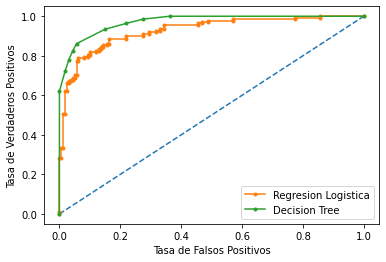

In [82]:
ns_probs = [0 for _ in range(len(y))]
RL_props = model_RL.predict_proba(X_scaled)
RL_props = RL_props[:, 1]
DT_props = model_DT.predict_proba(X_scaled)
DT_props = DT_props[:, 1]
ns_auc = roc_auc_score(y, ns_probs)
RL_auc = roc_auc_score(y, RL_props)
DT_auc = roc_auc_score(y, DT_props)

print('Regresion Logistica: ROC AUC = %.3f' % (RL_auc))
print('Decision Tree: ROC AUC = %.3f' % (DT_auc))

ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
rL_fpr, rL_tpr, _ = roc_curve(y, RL_props)
dt_fpr, dt_tpr, _ = roc_curve(y, DT_props)

plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(rL_fpr, rL_tpr, marker='.', label='Regresion Logistica')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()

Feature 0: age, Score: 0.35696
Feature 1: trestbps, Score: 0.30389
Feature 2: chol, Score: 0.80464
Feature 3: thalach, Score: -0.31117
Feature 4: oldpeak, Score: 0.79667
Feature 5: ca, Score: 2.43073
Feature 6: sex_Male, Score: 1.00730
Feature 7: cp_atypical angina, Score: -0.09788
Feature 8: cp_non-anginal pain, Score: 0.37162
Feature 9: cp_typical angina, Score: 1.45197
Feature 10: fbs_fastingBloodSugar_true, Score: -0.32109
Feature 11: restecg_Normal, Score: -0.46580
Feature 12: restecg_ST-T wave abnormality, Score: 0.18057
Feature 13: exang_Yes Angina, Score: -0.71493
Feature 14: slope_flat, Score: 0.40068
Feature 15: slope_upsloping, Score: -0.65211
Feature 16: thal_normal, Score: -0.54407
Feature 17: thal_reversable defect, Score: 0.91161


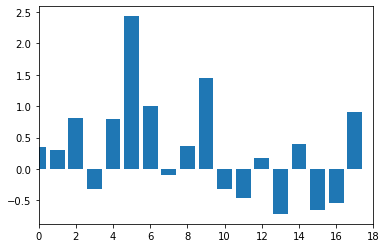

In [259]:
for i,v,o in zip(importance, list(range(0,len(X.columns))) ,list(X.columns)):
    print('Feature {}: {}, Score: %.5f'.format(v,o) % (i))
plt.bar([x for x in range(len(importance))], importance,)
plt.xlim([0, 18])
plt.show()

# 5. Representación gráfica
Este punto ha sido resuelto a lo largo de la práctica.

# 6. Resolución del problema
**A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

# 7. Código
El código se ha ido viendo a lo largo de la práctica. Se encuentra recopilado en formato .py en el repositorio Git creado bajo el nombre de xxxNOMBRExxx.

# 8. Vídeo
**Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/...), junto con enlace al repositorio Git entregado.**

# Contribuciones

In [ ]:
contribuciones = pd.DataFrame()
contribuciones['Contribuciones'] = ['Investigación previa', 'Redacción de las respuestas', 'Desarrollo del código', 'Participación en el vídeo']
contribuciones['Firma'] = ['Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca']
contribuciones

***